# STEP2. オレオレ地方を生成

In [12]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import hashlib
import random

In [13]:
# マップサイズ（ピクセル）の設定
map_width = 60
map_height = 40

In [14]:
# クラスタリングと街サイズの計算
def cluster_points(reduced_vectors, map_width, map_height):
    clusters = []
    for vector in reduced_vectors:
        placed = False
        for cluster in clusters:
            if np.linalg.norm(cluster['center'] - vector) < min(map_height, map_width) * 0.15:
                cluster['points'].append(vector)
                cluster['center'] = np.mean(cluster['points'], axis=0)
                placed = True
                break
        
        if not placed:
            clusters.append({'center': vector, 'points': [vector]})
    
    cluster_sizes = [len(cluster['points']) for cluster in clusters]
    return clusters, cluster_sizes

df_embeddings = pd.read_csv("embeddings.csv")

embeddings = df_embeddings[["0", "1"]].values
embeddings -= embeddings.min(axis=0)
embeddings /= embeddings.max(axis=0)
embeddings[:, 0] *= (map_width * 0.8 - 1)
embeddings[:, 1] *= (map_height * 0.8 - 1)
embeddings[:, 0] += map_width * 0.1
embeddings[:, 1] += map_height * 0.1

clusters, cluster_sizes = cluster_points(embeddings, map_width, map_height)

In [15]:
# 道路のデータ生成
import numpy as np
from scipy.spatial import distance_matrix
from itertools import combinations

def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    rootX = find(parent, x)
    rootY = find(parent, y)
    
    if rank[rootX] < rank[rootY]:
        parent[rootX] = rootY
    elif rank[rootX] > rank[rootY]:
        parent[rootY] = rootX
    else:
        parent[rootY] = rootX
        rank[rootX] += 1

def generate_road_data(clusters):
    num_clusters = len(clusters)
    positions = [cluster['center'] for cluster in clusters]
    # すべてのクラスタ間の距離行列を算出
    dist_matrix = distance_matrix(positions, positions)
    
    # すべての辺を作成し、それに対応する距離を配列に格納
    edge_list = []
    for i, j in combinations(range(num_clusters), 2):
        edge_list.append((dist_matrix[i][j], i, j))
    
    # 距離に基づいてエッジをソート
    edge_list.sort()

    parent = list(range(num_clusters))
    rank = [0] * num_clusters
    roads = []

    for dist, i, j in edge_list:
        root_i = find(parent, i)
        root_j = find(parent, j)
        
        # サイクルが生じない場合にのみ、辺を追加
        if root_i != root_j:
            roads.append((clusters[i]['center'], clusters[j]['center']))
            union(parent, rank, root_i, root_j)

    return roads

roads = generate_road_data(clusters)

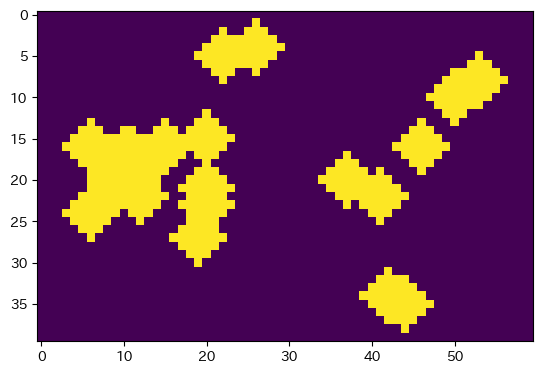

In [16]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# 起伏画像の作成
def create_relief_image(map_width, map_height, points):
    # img = Image.new('L', (map_width, map_height), 0)
    # pixels = img.load()
    # _img = Image.new('L', (map_width, map_height), 0)
    # _pixels = img.load()

    pixels = np.zeros((map_width, map_height))
    _pixels = np.zeros((map_width, map_height))
    
    for point in points:
        x, y = int(point[0]), int(point[1])
        pixels[x, y] = 1
        _pixels[x, y] = 1
        
    for _ in range(3):
        for x in range(map_width):
            for y in range(map_height):
                if pixels[x, y] == 0:
                    neighbors = []
                    if x - 1 >= 0: neighbors.append(pixels[x - 1, y])
                    if x + 1 <= map_width - 1: neighbors.append(pixels[x + 1, y])
                    if y - 1 >= 0: neighbors.append(pixels[x, y - 1])
                    if y + 1 <= map_height - 1: neighbors.append(pixels[x, y + 1])
                    
                    if any(neighbors):
                        _pixels[x, y] = 1

        pixels = pixels + _pixels
        _pixels = pixels.copy()
    
    # img = Image.eval(_img, lambda x: min(x, 3))  # 3を超えないようクリッピング
    return (pixels + _pixels).T.clip(0, 1)


# SHA256ハッシュを用いたシード生成
keywords = df_embeddings["keywords"].values
hash_input = "".join(keywords).encode('utf-8')
unique_seed = hashlib.sha256(hash_input).hexdigest()

relief_img = create_relief_image(map_width, map_height, embeddings)
plt.imshow(relief_img)

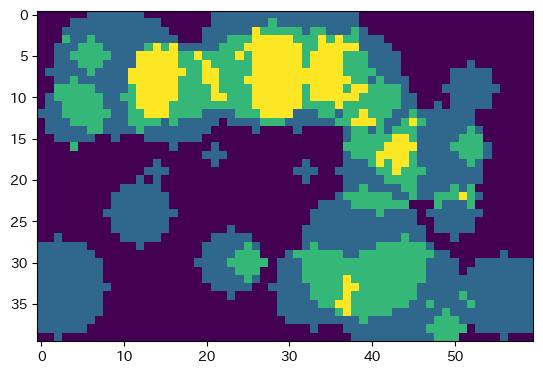

In [17]:
# シード起伏画像の作成
def create_seed_relief_image(map_width, map_height, seed):
    random.seed(seed)
    pixels = np.zeros((map_width, map_height))
    
    for _ in range(40):
        x, y = random.randint(0, map_width-1), random.randint(0, map_height-1)
        radius = random.randint(int(map_height * 0.02), int(map_height * 0.2))
        for dx in range(-radius, radius+1):
            for dy in range(-radius, radius+1):
                if (0 <= x + dx < map_width) and (0 <= y + dy < map_height) and (dx*dx + dy*dy <= radius*radius):
                    pixels[x + dx, y + dy] += 1

    pixels -= 1
    pixels = pixels.clip(-1 , 2)
    return pixels.T

seed_relief_img = create_seed_relief_image(map_width, map_height, int(unique_seed, 16))
plt.imshow(seed_relief_img)

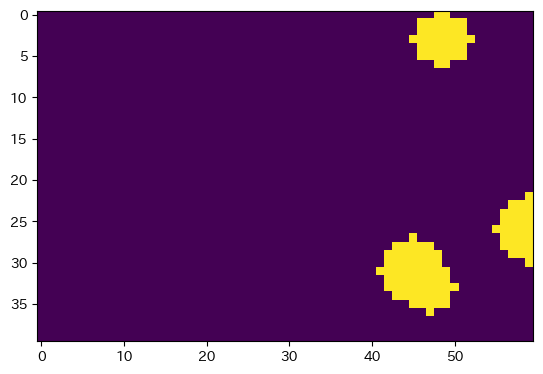

In [18]:
# シード地形画像の作成
def create_seed_terrain_image(map_width, map_height, seed, value=1, n_repeat=20, min_radius=0.01, max_radius=0.2):
    random.seed(seed)
    pixels = np.zeros((map_width, map_height))
    
    for _ in range(n_repeat):
        x, y = random.randint(0, map_width-1), random.randint(0, map_height-1)
        radius = random.randint(int(map_height * min_radius), int(map_height * max_radius))
        for dx in range(-radius, radius+1):
            for dy in range(-radius, radius+1):
                if (0 <= x + dx < map_width) and (0 <= y + dy < map_height) and (dx*dx + dy*dy <= radius*radius):
                    pixels[x + dx, y + dy] += 1

    pixels = pixels.clip(0, 1) * value
    return pixels.T

seed_sand_img = create_seed_terrain_image(map_width, map_height, int(unique_seed, 16) + 1, 4, 5, 0.01, 0.1)
plt.imshow(seed_sand_img)

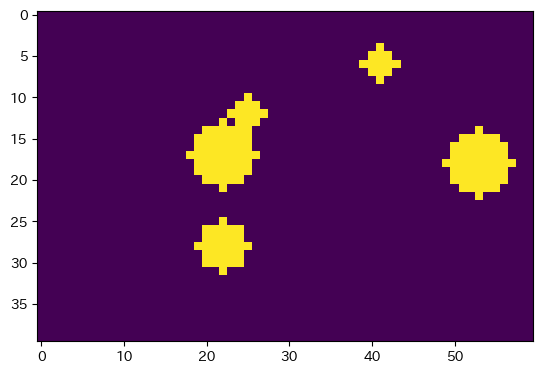

In [19]:
seed_rock_img = create_seed_terrain_image(map_width, map_height, int(unique_seed, 16) + 2, 5, 5, 0.01, 0.1)
plt.imshow(seed_rock_img)

In [20]:
_relief_img_composite = relief_img + seed_relief_img
_relief_img_composite[(_relief_img_composite <= 0) & (relief_img == 1)] = 1

_relief_img_composite[(_relief_img_composite >= 1) & (seed_sand_img == 4)] = 4
_relief_img_composite[(_relief_img_composite >= 1) & (seed_rock_img == 5)] = 5

relief_img_composite = Image.fromarray(_relief_img_composite)

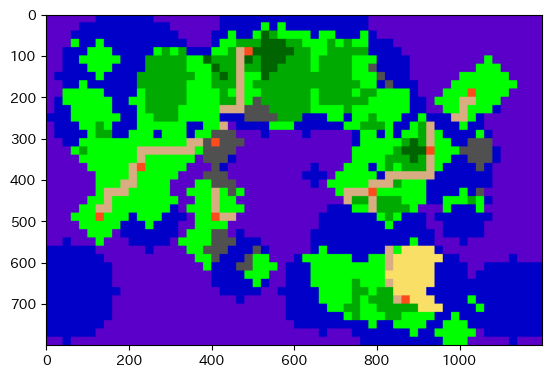

In [21]:
# 地図の統合と描画
def draw_map(relief_img_composite, color_map, roads, cluster_centers, cluster_sizes, map_width, map_height, seed):
    # 地形マップを生成
    terrain_map = Image.new("RGB", (map_width, map_height), "blue")
    relief_pixels = relief_img_composite.load()
    
    terrain_pixels = terrain_map.load()
    
    for x in range(map_width):
        for y in range(map_height):
            height = relief_pixels[x, y]
            terrain_pixels[x, y] = color_map.get(height, (0, 0, 255))
    
    # 道路マップを生成
    road_map = Image.new("RGBA", (map_width, map_height), (0, 0, 0, 0))
    draw = ImageDraw.Draw(road_map)
    
    for road in roads:
        start = tuple(road[0].astype(int))
        end = tuple(road[1].astype(int))
        # 直線描画の場合
        # draw.line([start, end], fill=(255, 255, 255, 150), width=1)

        # マンハッタン式描画
        x1, y1 = start
        x2, y2 = end
        delta_x = x2 - x1
        delta_y = y2 - y1
        x_moves = [(1, 0)] * delta_x if delta_x > 0 else [(-1, 0)] * abs(delta_x)
        y_moves = [(0, 1)] * delta_y if delta_y > 0 else [(0, -1)] * abs(delta_y)
        moves = x_moves + y_moves
        random.seed(seed)
        random.shuffle(moves)

        x, y = start
        draw.line([start, start], fill=(255, 255, 255, 150), width=1)
        for x_d, y_d in moves:
            x += x_d
            y += y_d
            draw.line([(x, y), (x, y)], fill=(255, 255, 255, 150), width=1)
            if 1 <= relief_pixels[x, y] <= 2:
                terrain_pixels[x, y] = color_map.get(6, (0, 0, 255))
    
    max_cluster_size = max(cluster_sizes)
    for i, center in enumerate(cluster_centers):
        x, y = center.astype(int)
        cluster_size = cluster_sizes[i] / max_cluster_size
        if cluster_size >= 0.7:
            x_size, y_size = 2, 2
        elif cluster_size >= 0.3:
            x_size, y_size = 2, 1
        else:
            x_size, y_size = 1, 1

        ul = (x, y)
        lr = (x + x_size // 2, y + y_size // 2)
        draw.rectangle([ul, lr], fill=(255, 0, 0, 255))
        terrain_pixels[ul] = color_map.get(7, (0, 0, 255))
        
    
    # 地形マップに道路を合成
    final_map = Image.alpha_composite(terrain_map.convert("RGBA"), road_map)
    return terrain_map.convert("RGBA"), road_map, final_map


color_map = {
        -1: (90, 0, 200),  # 深海
        0: (0, 0, 200),     # 海
        1: (0, 255, 0),     # 平地
        2: (0, 170, 0),   # 林、森
        3: (0, 100, 0),    # 山
        4: (250, 223, 102),    # 砂漠
        5: (80, 80, 80),    # 岩
        6: (217, 173, 130),    # 道
        7: (252, 76, 28), # 街
    }

terrain_map, road_map, final_map = draw_map(
    relief_img_composite,
    color_map,
    roads,
    [c['center'] for c in clusters],
    cluster_sizes,
    map_width,
    map_height,
    int(unique_seed, 16),
    )

terrain_map = terrain_map.resize((map_width * 20, map_height * 20), Image.Resampling.NEAREST)
terrain_map.save('terrain_map.png', 'PNG')

road_map = road_map.resize((map_width * 20, map_height * 20), Image.Resampling.NEAREST)
road_map.save('road_map.png', 'PNG')

final_map = final_map.resize((map_width * 20, map_height * 20), Image.Resampling.NEAREST)
final_map.save('final_map.png', 'PNG')

plt.imshow(terrain_map)

100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


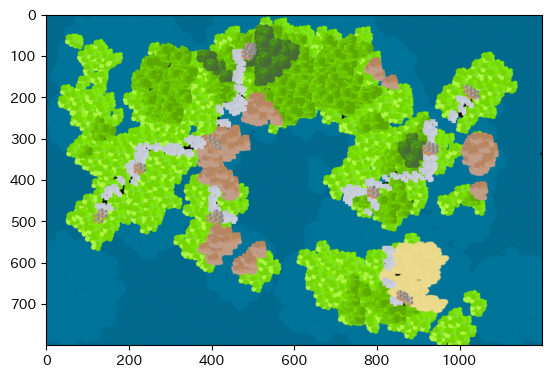

In [22]:
# テクスチャ画像でマップを描画
from tqdm import tqdm

terrain_pixels = terrain_map.load()
texture_map = Image.new("RGBA", terrain_map.size, (0, 0, 0, 255))
texture_size = 40

for k in tqdm(color_map.keys()):
    try:
        item = Image.open(f"./images/{k}.png").resize((texture_size, texture_size))

        for _ in range(10000):
            x, y = random.randint(0, texture_map.size[0] - 1), random.randint(0, texture_map.size[1] - 1)
            if terrain_pixels[x, y][:3] == color_map[k]:
                _img = Image.new("RGBA", texture_map.size, (255, 255, 255, 0))
                _img.paste(item, (x - texture_size // 2, y - texture_size // 2))
                texture_map = Image.alpha_composite(texture_map, _img)
    except:
        pass

texture_map.save('texture_map.png', 'PNG')
plt.imshow(texture_map)